# Analysis of results of experiments for coursework 2 (s1700260)

In this notebook, the data gathered for the different experiments is analyzed with plots.

The experiments were run in the command line as follows:

    For baseline systems:

      python cw2_a1.py exp_name model_type

    For different stochastic gradient descent 

      python cw2_a3.py exp_name model_type

    For batch normalization

      python cw2_a7.py exp_name model_type
      
    For convolutional networks
    
      python cw2_b5.py exp_name model_type
      
      
For every experiment exp_name is the name of the experiment (any strine). For neural networks, model_type can be 1 for a single convolutional layer network, or 2 for a two convolutional layers network. For the rest of systems, model_type can be 0 for a model with dropout, 1 for a network with L2 regularization, 2 for a network that uses histogram of gradients as features.

The output of every script is a text file with the statistics for every experiment.

In [19]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import OrderedDict
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider
from skimage.feature import hog
%matplotlib inline

## The dataset

In [21]:
# from https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/d479f43a-7bbb-4de7-9452-f6b991ece599
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

def extract_features(image):
    # Define HOG parameters
    orient = 9
    pix_per_cell = 14
    cell_per_block = 1
    
    hog_feats = get_hog_features(
            image, 
            orient, 
            pix_per_cell, 
            cell_per_block, 
            vis=False, 
            feature_vec=True
        )

    return hog_feats

def extract_hog(data_set):
    num_samples, size_sample = data_set.shape
    size_digit = int(np.sqrt(size_sample))
    
    reshaped_data = data_set.reshape((num_samples, size_digit, size_digit))

    hog_data = []

    for elem in reshaped_data:
        hog_data.append(extract_features(elem))

    return np.array(hog_data)

def load_data_hog(rng, batch_size=100):
    train_data, valid_data, test_data = load_data(rng, batch_size)

    train_data.inputs = extract_hog(train_data.inputs)
    valid_data.inputs = extract_hog(valid_data.inputs)
    test_data.inputs = extract_hog(test_data.inputs)

    return train_data, valid_data, test_data

def load_data(rng, batch_size=100):
    # The below code will set up the data providers, random number
    # generator and logger objects needed for training runs. As
    # loading the data from file take a little while you generally
    # will probably not want to reload the data providers on
    # every training run. If you wish to reset their state you
    # should instead use the .reset() method of the data providers.
    
    # Set up a logger object to print info about the training run to stdout
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.handlers = [logging.StreamHandler()]

    # Create data provider objects for the MNIST data set
    train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
    valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
    test_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

    # Normalize data
    train_data.inputs = normalize_data(train_data.inputs)
    valid_data.inputs = normalize_data(valid_data.inputs)
    test_data.inputs = normalize_data(test_data.inputs)

    return train_data, valid_data, test_data

def normalize_data(data):
    mean = np.mean(data)
    std = np.std(data)

    return (data - mean) / std

trd, vad, tsd = load_data(np.random.RandomState(123456), 100)

print("Number of elements in training set: {:d}".format(trd.inputs.shape[0]))
print("Number of elements in validation set: {:d}".format(vad.inputs.shape[0]))
print("Number of elements in testing set: {:d}".format(tsd.inputs.shape[0]))

trd, vad, tsd = load_data_hog(np.random.RandomState(123456), 100)
print("Number of elements in features in hog: {:d}".format(trd.inputs.shape[1]))


['inputs', 'targets']
['inputs', 'targets']
['inputs', 'targets']
Number of elements in training set: 100000
Number of elements in validation set: 15800
Number of elements in testing set: 15800
['inputs', 'targets']
['inputs', 'targets']
['inputs', 'targets']


/mnt/linux_shared/shared/anaconda3/envs/mlp/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of elements in features in hog: 36


## 1. Plots for baseline experiments

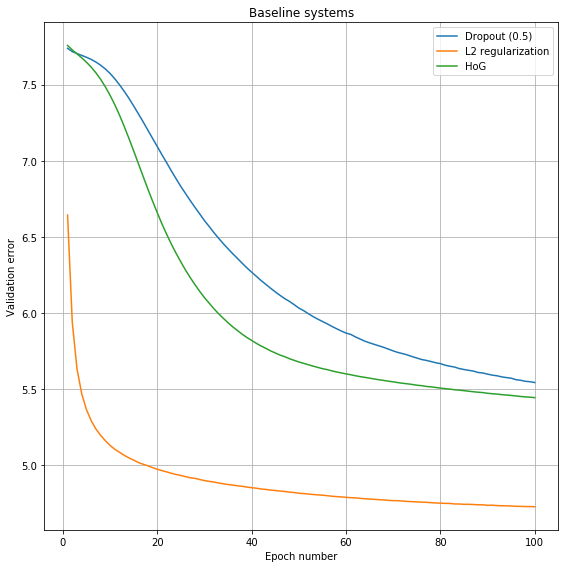

In [101]:
def plot_metrics_baseline(exp_name="exp0"):
    networks = ["dropout", "regularization", "hog"]
    legends = ["Dropout (0.5)", "L2 regularization", "HoG"]
    
    # train err | train acc | val err | val acc | params
    metrics_name = ["Train error", "Train Accuracy ", "Validation error", "Validation accuracy"]

    metrics_list = [OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()]

    for net in networks:
        file_name = "{:s}_network_{:s}_log.txt".format(exp_name, net)
        net_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)

        assert len(metrics_list) == net_metrics.shape[1]

        for idx, ml in enumerate(metrics_list):
            ml[net] = net_metrics[:, idx]            

    col = 2
    row = len(metrics_list)
    row /= 2
    row = int(row)
    f, ax = plt.subplots(row, col, figsize=(8, 8))
    c = 0
    for i in range(row):
        for j in range(col):
            a = ax[j, i]
            for leg, net in zip(legends, networks):
                ml = metrics_list[c]
                a.plot(np.arange(1, len(ml[net])), ml[net][1:], label=leg)

            a.legend(loc=0)
            a.set_xlabel("Epoch number")
            a.set_ylabel(metrics_name[c])
            a.set_title("Baseline systems")
            a.grid()

            c += 1
    
    f.tight_layout()
    f.savefig("{:s}_metrics.svg".format(exp_name), dpi=200)

def plot_metrics_baseline_report(exp_name="exp0"):
    networks = ["dropout", "regularization", "hog"]
    legends = ["Dropout (0.5)", "L2 regularization", "HoG"]
    
    # train err | train acc | val err | val acc | params
    metrics_name = ["Train error", "Train Accuracy ", "Validation error", "Validation accuracy"]

    metrics_list = [OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()]


    for net in networks:
        file_name = "{:s}_network_{:s}_log.txt".format(exp_name, net)
        net_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)

        assert len(metrics_list) == net_metrics.shape[1]

        for idx, ml in enumerate(metrics_list):
            ml[net] = net_metrics[:, idx]            

    f, a = plt.subplots(figsize=(8, 8))

    for leg, net in zip(legends, networks):
        ml = metrics_list[2]
        a.plot(np.arange(1, len(ml[net])), ml[net][1:], label=leg)

    a.legend(loc=0)
    a.set_xlabel("Epoch number")
    a.set_ylabel(metrics_name[2])
    a.set_title("Baseline systems")
    a.grid()
    
    f.tight_layout()
    f.savefig("{:s}_metrics.svg".format(exp_name), dpi=200)

#plot_metrics_baseline()
plot_metrics_baseline_report("exp0")

## 2. Plots for learning rules

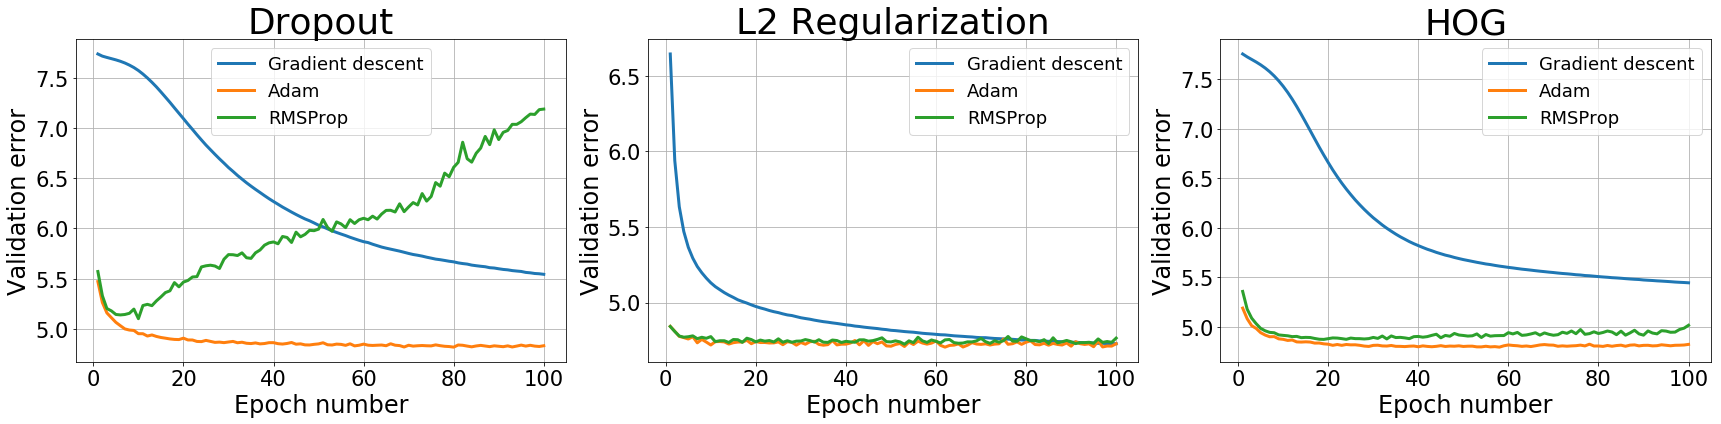

In [63]:
def plot_metric_learning_rules(exp_name):
    learning_rules = ["", "AdamLearningRule", "RMSPropRule"]
    learning_tags = ["Baseline", "Adam", "RMS"]
    
    networks = ["dropout", "regularization", "hog"]
    legends = ["Dropout (0.5)", "L2 regularization", "HoG"]
    
    # train err | train acc | val err | val acc | params
    metrics_name = ["Train error", "Train Accuracy ", "Validation error", "Validation accuracy"]

    for net in networks:
        
        metrics_list = [OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()]

        for rule in learning_rules:
            file_name = "{:s}_network_{:s}_{:s}_log.txt".format(exp_name, net, rule)
            rule_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)

            assert len(metrics_list) == rule_metrics.shape[1]

            for idx, ml in enumerate(metrics_list):
                ml[rule] = rule_metrics[:, idx]
                
        col = 2
        row = len(metrics_list)
        row /= 2
        row = int(row)
        f, ax = plt.subplots(row, col, figsize=(8, 8))
        c = 0
        for i in range(row):
            for j in range(col):
                a = ax[j, i]
                for tag, rule in zip(learning_tags, learning_rules):
                    ml = metrics_list[c]
                    a.plot(np.arange(1, len(ml[rule])), ml[rule][1:], label=tag)

                a.legend(loc=0)
                a.set_xlabel("Epoch number")
                a.set_ylabel(metrics_name[c])
                a.set_title(net)
                a.grid()

                c += 1

        f.tight_layout()
        f.savefig("{:s}_{:s}_metrics.svg".format(exp_name, net), dpi=200)

def plot_metric_learning_rules_report(exp_name0, exp_name1):
    networks = ["dropout", "regularization", "hog"]
    network_tags = ["Dropout", "L2 Regularization", "HOG"]
    learning_rules = ["AdamLearningRule", "RMSPropRule"]
    metrics_name = ["Train error", "Train Accuracy ", "Validation error", "Validation accuracy"]
    
    f, subplts = plt.subplots(1, 3, figsize=(24, 6))
    
    for net, net_tag, a in zip(networks, network_tags, subplts):
        metrics_list = [OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()]
        for rule in learning_rules:
            file_name = "{:s}_network_{:s}_{:s}_log.txt".format(exp_name1, net, rule)
            rule_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)
            
            assert len(metrics_list) == rule_metrics.shape[1]

            # Add the values to the ordered dict for the metric
            for idx, ml in enumerate(metrics_list):
                ml[rule] = rule_metrics[:, idx]

        file_name = "{:s}_network_{:s}_log.txt".format(exp_name0, net)
        net_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)
        
        # Add the values to the ordered dict for the metric
        for idx, ml in enumerate(metrics_list):
            ml["Baseline"] = net_metrics[:, idx]
            
        #f, a = plt.subplots(figsize=(8, 8))

        for rule_tag, nick in zip(["Baseline", "AdamLearningRule", "RMSPropRule"], ["Gradient descent", "Adam", "RMSProp"]):
            ml = metrics_list[2]
            a.plot(
                np.arange(1, len(ml[rule_tag])), ml[rule_tag][1:], 
                label=nick,
                linewidth=3)
            a.tick_params(axis='x', labelsize=21)
            a.tick_params(axis='y', labelsize=21)

        a.legend(loc=0, fontsize=18)
        a.set_xlabel("Epoch number", size=24)
        a.set_ylabel(metrics_name[2], size=24)
        a.set_title(net_tag, size=36)
        a.grid()

        f.tight_layout()
        f.savefig("{:s}_metrics.pdf".format(exp_name1), dpi=200)
            
plot_metric_learning_rules_report("exp0", "exp1")

## 2. Plots for batch normalization

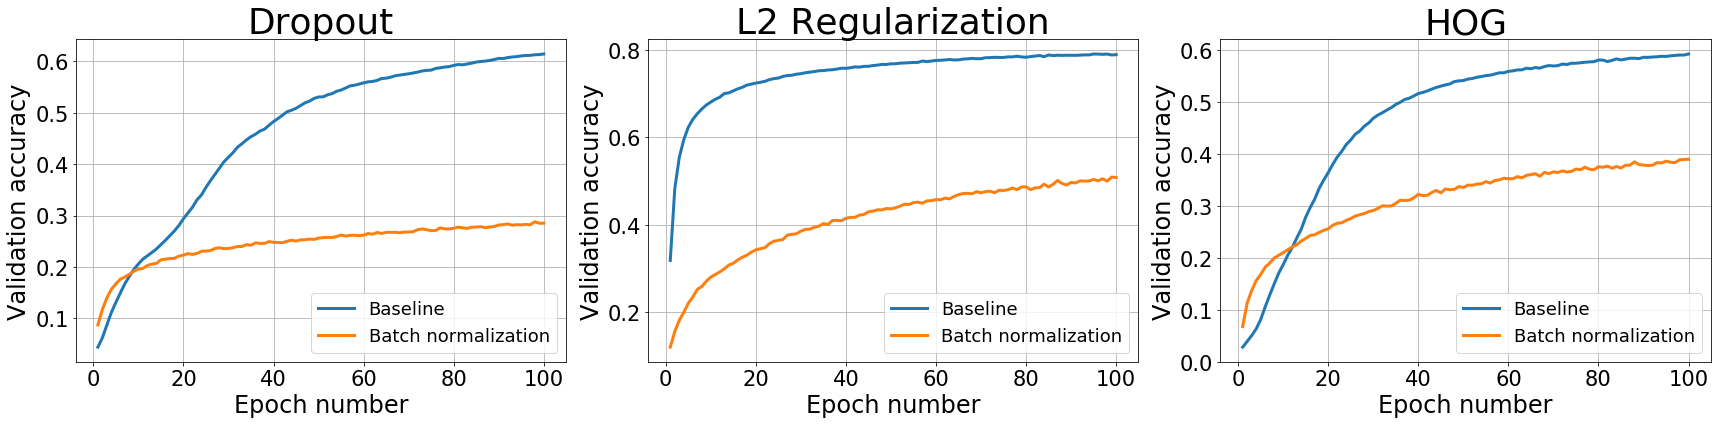

In [100]:
def plot_metric_bn_report(exp_name0, exp_name1):
    networks = ["dropout", "regularization", "hog"]
    network_tags = ["Dropout", "L2 Regularization", "HOG"]
    norms = ["bn"]
    metrics_name = ["Train error", "Train Accuracy ", "Validation error", "Validation accuracy"]
    
    f, subplts = plt.subplots(1, 3, figsize=(24, 6))
    
    for net, net_tag, a in zip(networks, network_tags, subplts):
        metrics_list = [OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()]
        for norm in norms:
            file_name = "{:s}_network_{:s}_{:s}_log.txt".format(exp_name1, net, norm)
            rule_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)
            
            assert len(metrics_list) == rule_metrics.shape[1]

            # Add the values to the ordered dict for the metric
            for idx, ml in enumerate(metrics_list):
                ml[norm] = rule_metrics[:, idx]

        file_name = "{:s}_network_{:s}_log.txt".format(exp_name0, net)
        net_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)
        
        # Add the values to the ordered dict for the metric
        for idx, ml in enumerate(metrics_list):
            ml["Baseline"] = net_metrics[:, idx]
            
        #f, a = plt.subplots(figsize=(8, 8))

        for rule_tag, nick in zip(["Baseline", "bn"], ["Baseline", "Batch normalization"]):
            ml = metrics_list[3]
            a.plot(
                np.arange(1, len(ml[rule_tag])), ml[rule_tag][1:], 
                label=nick,
                linewidth=3)
            a.tick_params(axis='x', labelsize=21)
            a.tick_params(axis='y', labelsize=21)

        a.legend(loc=0, fontsize=18)
        a.set_xlabel("Epoch number", size=24)
        a.set_ylabel(metrics_name[3], size=24)
        a.set_title(net_tag, size=36)
        a.grid()

        f.tight_layout()
        f.savefig("{:s}_metrics.pdf".format(exp_name1), dpi=200)
            
plot_metric_bn_report("exp0", "exp3")

## 3. Plots for CNNs

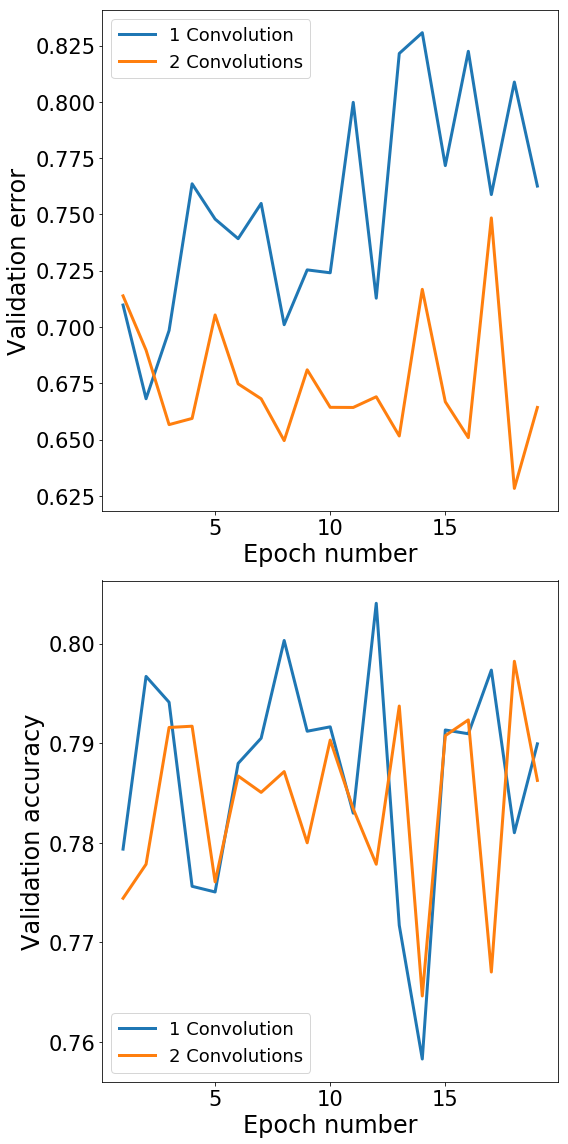

In [99]:
def plot_metric_cnn_report(exp_name):
    networks = ["cnn1", "cnn2", "hog"]
    network_tags = ["1 Convolution", "2 Convolutions"]
    metrics_name = ["Validation error", "Validation accuracy", "Train error", "Train Accuracy"]
    metrics_list = [OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()]
    
    for net, net_tag in zip(networks, network_tags):
        file_name = "{:s}_{:s}_log.txt".format(exp_name, net)
        rule_metrics = np.loadtxt(file_name, delimiter=',', skiprows=2)

        assert len(metrics_list) == rule_metrics.shape[1]

        # Add the values to the ordered dict for the metric
        for idx, ml in enumerate(metrics_list):
            ml[net] = rule_metrics[:, idx]

    f, ax = plt.subplots(2, 1, figsize=(8, 16))

    c = 0
    for a in ax:
        for net, net_tag in zip(networks, network_tags):
            ml = metrics_list[c]
            a.plot(
                np.arange(1, len(ml[net])), ml[net][1:], 
                label=net_tag,
                linewidth=3)
            a.tick_params(axis='x', labelsize=21)
            a.tick_params(axis='y', labelsize=21)

            a.legend(loc=0, fontsize=18)
            a.set_xlabel("Epoch number", size=24)
            a.set_ylabel(metrics_name[c], size=24)
            a.grid()
        c = c + 1

    f.tight_layout()
    f.savefig("{:s}_metrics.pdf".format(exp_name), dpi=200)
            
plot_metric_cnn_report("expa")